In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [636]:
# load the data in training_dictionary.txt
with open("training_dictionary.txt", "r") as file:
    words = file.read().splitlines()

In [637]:
# Filter down to words less than 3 characters
max_length = 3
words = [word for word in words if len(word) == max_length]

In [638]:
print(len(words))
words[:10]

1249


['las', 'shu', 'ian', 'tig', 'aum', 'tay', 'ama', 'inn', 'wun', 'yah']

In [639]:
len("".join(words))

3747

In [640]:
longest_word = max(words, key=len)
print(longest_word, len(longest_word))

las 3


In [641]:
vocab = set("".join(words))
vocab = ["_"] + sorted(list(vocab))
vocab_size = len(vocab)
print(vocab_size)
stoi = {char: i for i, char in enumerate(vocab)}
itos = {i: char for char, i in stoi.items()}
print(stoi)
print(itos)

27
{'_': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '_', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [642]:
# create a dataset where each character is masked with an underscore
block_size = max_length
dataset = []
# Truncate word to block_size or fill them with '.' if it's too short. Use '_' for the single masked character. There must only be one '_' per word.
truncated_words = []
for word in words:
    # Pad shorter words with '.' to match block_size
    # if len(word) < block_size:
    #     word = word + "." * (block_size - len(word))

    # Use sliding window to generate subwords
    for i in range(len(word) - block_size + 1):
        subword = word[i : i + block_size]
        truncated_words.append(subword)

print(len(truncated_words))
truncated_words[:10]

1249


['las', 'shu', 'ian', 'tig', 'aum', 'tay', 'ama', 'inn', 'wun', 'yah']

In [643]:
def masked_words(word):
    if not word:
        return []

    result = []

    # Get unique characters in the word
    unique_chars = list(set(word))

    # Generate all possible combinations of which characters to mask
    # For n unique characters, we have 2^n possibilities
    for i in range(1, 2 ** len(unique_chars)):  # Start from 1 to exclude no masks
        chars_to_mask = set()

        # Determine which characters to mask based on bit pattern
        for j in range(len(unique_chars)):
            if i & (1 << j):
                chars_to_mask.add(unique_chars[j])

        # Create the masked string
        masked = ""
        for char in word:
            if char in chars_to_mask:
                masked += "_"
            else:
                masked += char

        # Create a tuple for each masked character type
        # for char in chars_to_mask:
        result.append((masked, word))

    return result


print(masked_words("app"))
print(masked_words("xyz"))

[('_pp', 'app'), ('a__', 'app'), ('___', 'app')]
[('xy_', 'xyz'), ('x_z', 'xyz'), ('x__', 'xyz'), ('_yz', 'xyz'), ('_y_', 'xyz'), ('__z', 'xyz'), ('___', 'xyz')]


In [644]:
dataset = []
for word in truncated_words:
    dataset.extend(masked_words(word))

# dataset = list(set(dataset))

# print the first 10 elements of the dataset
print(len(dataset))
print(dataset[:10])

8275
[('_as', 'las'), ('la_', 'las'), ('_a_', 'las'), ('l_s', 'las'), ('__s', 'las'), ('l__', 'las'), ('___', 'las'), ('sh_', 'shu'), ('_hu', 'shu'), ('_h_', 'shu')]


In [645]:
# convert the words to a list of ints
integerized_dataset = []
for word, label in dataset:
    integerized_dataset.append(
        ([stoi[char] for char in word], [stoi[char] for char in label])
    )

print(integerized_dataset[0])

([0, 1, 19], [12, 1, 19])


In [646]:
# create a pytorch dataset of word and label pairs
from torch.utils.data import Dataset
import random


class HangmanDataset(Dataset):
    def __init__(self, words):
        self.features = torch.tensor([x[0] for x in words])
        self.labels = torch.tensor([x[1] for x in words])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


split_idx = int(len(integerized_dataset) * 1)
shuffled_integerized_dataset = list(integerized_dataset)
random.shuffle(shuffled_integerized_dataset)
train_split = shuffled_integerized_dataset[:split_idx]
val_split = shuffled_integerized_dataset[split_idx:]

train_dataset = HangmanDataset(train_split)
val_dataset = HangmanDataset(val_split)

print(len(train_dataset))
print(train_dataset[[0, 1, 2]])

print(len(val_dataset))

8275
(tensor([[ 0,  0,  0],
        [ 0,  0,  0],
        [11,  0,  0]]), tensor([[ 5, 12, 20],
        [ 4,  9,  4],
        [11,  1, 10]]))
0


In [647]:
# Create a transformer model for the hangman game

import torch
import torch.nn as nn
import torch.optim as optim
import math
from tqdm import tqdm

d_model = 256
nhead = 8
num_layers = 3

device = "mps" if torch.backends.mps.is_available() else "cpu"


class HangmanTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dropout=0):
        super(HangmanTransformer, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dropout = dropout

        # Create positional encoding matrix
        self.embedding = nn.Embedding(vocab_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout
        )
        self.position_embedding_table = nn.Embedding(block_size, d_model)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.ln_f = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src):
        src = self.embedding(src)
        pos_emb = self.position_embedding_table(
            torch.arange(block_size).to(device)
        )  # (T,C)
        src = src + pos_emb
        output = self.transformer_encoder(src)
        output = self.ln_f(output)
        logits = self.fc(output)
        return logits


# create a transformer model
model = HangmanTransformer(vocab_size, d_model, nhead, num_layers)

model.to(device)
# create a loss function
criterion = nn.CrossEntropyLoss()

# create an optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# train the model
batch_size = 512
num_epochs = 20

lossi = []

for epoch in range(num_epochs):
    for i in (pbar := tqdm(range(0, len(train_dataset), batch_size))):
        # idx = torch.randint(0, len(train_dataset), (batch_size,))
        features, labels = train_dataset[i : i + batch_size]
        features = features.to(device)
        labels = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(features)

        # Calculate loss
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f}")
        lossi.append(loss.item())

Epoch 1/20 | Loss: 1.6845: 100%|██████████| 17/17 [00:00<00:00, 22.83it/s]
Epoch 2/20 | Loss: 1.6177: 100%|██████████| 17/17 [00:00<00:00, 37.85it/s]
Epoch 3/20 | Loss: 1.5689: 100%|██████████| 17/17 [00:00<00:00, 35.80it/s]
Epoch 4/20 | Loss: 1.5373: 100%|██████████| 17/17 [00:00<00:00, 30.67it/s]
Epoch 5/20 | Loss: 1.5015: 100%|██████████| 17/17 [00:00<00:00, 30.10it/s]
Epoch 6/20 | Loss: 1.4576: 100%|██████████| 17/17 [00:00<00:00, 31.65it/s]
Epoch 7/20 | Loss: 1.4226: 100%|██████████| 17/17 [00:00<00:00, 34.46it/s]
Epoch 8/20 | Loss: 1.3959: 100%|██████████| 17/17 [00:00<00:00, 38.22it/s]
Epoch 9/20 | Loss: 1.3605: 100%|██████████| 17/17 [00:00<00:00, 38.14it/s]
Epoch 10/20 | Loss: 1.3870: 100%|██████████| 17/17 [00:00<00:00, 33.92it/s]
Epoch 11/20 | Loss: 1.3707: 100%|██████████| 17/17 [00:00<00:00, 34.85it/s]
Epoch 12/20 | Loss: 1.3393: 100%|██████████| 17/17 [00:00<00:00, 31.54it/s]
Epoch 13/20 | Loss: 1.2980: 100%|██████████| 17/17 [00:00<00:00, 29.79it/s]
Epoch 14/20 | Loss: 1

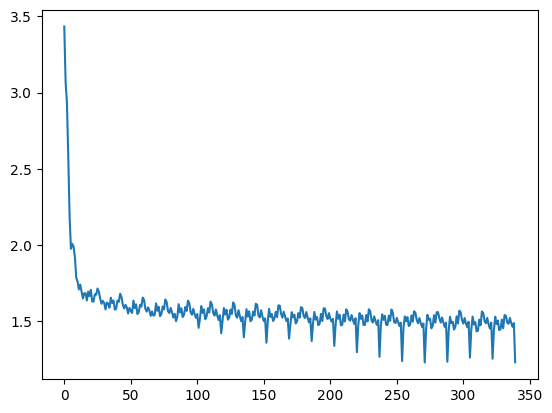

In [648]:
plt.plot(lossi)
plt.show()

In [649]:
model.eval()
with torch.no_grad():
    losses = []
    for i in (pbar := tqdm(range(0, len(train_dataset), batch_size))):
        features, labels = train_dataset[i : i + batch_size]
        features = features.to(device)
        labels = labels.to(device)
        logits = model(features)
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
        losses.append(loss.item())
    print(np.mean(losses))

100%|██████████| 17/17 [00:00<00:00, 130.88it/s]

1.4552077125100529


In [650]:
# inference:


def predict(model, word, max_guesses=6, verbose=False):
    if verbose:
        print("word", word)
    guesses = []
    model.eval()
    with torch.no_grad():
        while True:
            # print(guesses)
            masked_word = "".join(
                ["_" if guess not in guesses else guess for guess in word]
            )
            if verbose:
                print("masked_word", masked_word, guesses)
            if masked_word == word:
                break
            if len(guesses) >= max_guesses:
                break

            features = torch.tensor([[stoi[c] for c in masked_word]]).to(device)
            # print("features", features)
            logits = model.forward(features)
            probs = torch.softmax(logits, dim=2)
            # print("probs", probs)
            # print("max", torch.max(probs, dim=2).values)
            most_confident_index = torch.topk(
                torch.max(probs, dim=2).values, k=len(masked_word), dim=1
            ).indices[0]
            if verbose:
                print("most_confident_index", most_confident_index)
            indices = torch.topk(probs, k=vocab_size - 1, dim=2).indices
            # print("indices", indices)
            for i in most_confident_index:
                if masked_word[i] == "_":
                    letter_guesses = [itos[j.item()] for j in indices[0, i]]
                    break
            if verbose:
                print("letter_guesses", letter_guesses)
            for letter_guess in letter_guesses:
                if letter_guess not in guesses and letter_guess != "_":
                    guesses.append(letter_guess)
                    if letter_guess in word or len(guesses) == max_guesses:
                        break
                    # break
    return masked_word, guesses


predict(model, truncated_words[1], max_guesses=6, verbose=True)

wins = 0
total = 0
for word in (pbar := tqdm(truncated_words)):
    masked_word, guesses = predict(model, word, max_guesses=6, verbose=False)
    if masked_word == word:
        wins += 1
    total += 1
    pbar.set_description(f"Win rate: {wins / total * 100:.2f}%")

word shu
masked_word ___ []
most_confident_index tensor([1, 0, 2], device='mps:0')
letter_guesses ['a', 'o', 'e', 'i', 'u', 'l', 'r', 's', 'h', 'y', 'm', 'n', 'd', 'w', 't', 'b', 'c', 'k', 'p', 'v', 'g', 'f', 'j', 'x', 'z', 'q']
masked_word __u ['a', 'o', 'e', 'i', 'u']
most_confident_index tensor([2, 1, 0], device='mps:0')
letter_guesses ['o', 'a', 'e', 'h', 'r', 's', 'n', 'y', 't', 'l', 'm', 'b', 'd', 'g', 'k', 'p', 'i', 'f', 'c', 'v', 'u', 'j', 'z', 'x', 'w', 'q']
masked_word _hu ['a', 'o', 'e', 'i', 'u', 'h']


Win rate: 11.13%: 100%|██████████| 1249/1249 [00:32<00:00, 38.17it/s]
